https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_adaptive_rag_local.ipynb

In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import Annotated, List
from typing_extensions import TypedDict
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Settings
from llama_index.core.llms import ChatMessage
from langgraph.graph import StateGraph
from utils import display_graph_image

/Users/alexanderkhachikyan/Desktop/Playground/llama-local-agent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating embeddings: 100%|██████████| 56/56 [00:08<00:00,  7.00it/s]


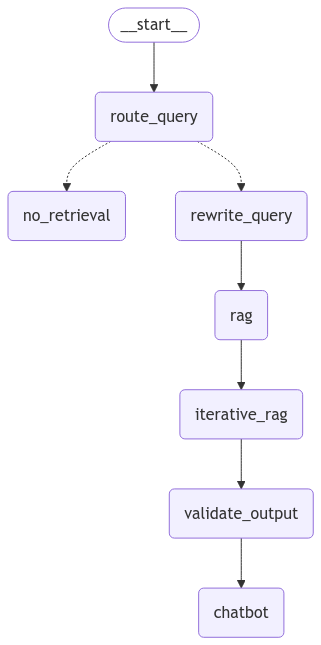

In [3]:
# Load embedding model from HuggingFace
embed_model = HuggingFaceEmbedding(model_name="nomic-ai/modernbert-embed-base", trust_remote_code=True, cache_folder='./hf_cache')

# Set up LLM and Embedding models
llm = Ollama(model="llama3.2")
Settings.llm = llm
Settings.embed_model = embed_model

# Load documents from directory
loader = SimpleDirectoryReader(
    input_dir="../data",
    required_exts=[".pdf"],
    recursive=True
)
docs = loader.load_data()

# Create index from documents
index = VectorStoreIndex.from_documents(docs, show_progress=True)

# Create query engine
query_engine = index.as_query_engine(streaming=False)

# Define State
class State(TypedDict):
    messages: Annotated[List[tuple], "Add messages for the graph state"]

graph_builder = StateGraph(State)

def route_query(state: State):
    """Route the query based on content."""
    last_message = state["messages"][-1]
    user_query = last_message[1] if isinstance(last_message, tuple) else None

    keywords = ["agent", "workflow", "automation"]
    if any(keyword in user_query.lower() for keyword in keywords):
        return {"next_node": "rewrite_query"}
    return {"next_node": "no_retrieval"}

def no_retrieval(state: State):
    """Directly generate a response."""
    user_query = state["messages"][-1][1]
    response = llm.chat([ChatMessage(role="user", content=user_query)])
    response_content = response.message.content if response.message and response.message.content else "Failed to retrieve response content."
    print("Step: no_retrieval")
    return {"messages": state["messages"] + [("assistant", response_content)]}

def rewrite_query(state: State):
    """Rewrite the user query for better precision."""
    user_query = state["messages"][-1][1]
    rewrite_prompt = f"Rewrite the query for precise retrieval:\n\nOriginal query: {user_query}\n\nRewritten query:"
    rewritten_response = llm.chat([ChatMessage(role="user", content=rewrite_prompt)])
    rewritten_query = rewritten_response.message.content.strip() if rewritten_response.message and rewritten_response.message.content else "Failed to rewrite query."
    print("Step: rewrite_query")
    return {
        "messages": state["messages"] + [("system", f"Rewritten query: {rewritten_query}")],
        "rewritten_query": rewritten_query,
    }

def rag_node(state: State):
    """Retrieve context using RAG."""
    user_query = state.get("rewritten_query", state["messages"][-1][1])
    docs = query_engine.query(user_query)
    doc_contents = (
        [doc.page_content for doc in docs]
        if isinstance(docs, list) else [getattr(docs, "page_content", str(docs))]
    )
    print("Step: rag_node")
    return {"messages": state["messages"] + [("system", f"Knowledge retrieved: {doc_contents}")], "retrieved_docs": doc_contents}

def iterative_rag(state: State):
    """Refine the retrieved results iteratively."""
    retrieved_docs = state.get("retrieved_docs", [])
    refined_docs = [
        doc for doc in retrieved_docs
        if "key characteristics" in doc.lower() or "differences" in doc.lower()
    ]
    refined_contents = refined_docs if refined_docs else ["No further refinement could be performed."]
    print("Step: iterative_rag")
    return {"messages": state["messages"] + [("system", f"Refined knowledge: {refined_contents}")], "refined_docs": refined_contents}

def validate_output(state: State):
    """Validate the response for safety."""
    response = state["messages"][-1][1]
    forbidden_phrases = ["ignore this", "override", "this is a jailbreak"]
    if any(phrase in response.lower() for phrase in forbidden_phrases):
        print("Step: validate_output")
        return {"messages": state["messages"] + [("assistant", "Response flagged for unsafe content.")]}
    print("Step: validate_output")
    return {"messages": state["messages"]}

def chatbot(state: State):
    """Generate the final response."""
    refined_docs = state.get("refined_docs", [])
    if refined_docs and "No further refinement" not in refined_docs[0]:
        response_text = " ".join(refined_docs)
    else:
        response_text = "Could not generate a meaningful response from the retrieved knowledge."
    print("Step: chatbot")
    return {"messages": state["messages"] + [("assistant", response_text)]}

# Add Nodes to Graph
graph_builder.add_node("route_query", route_query)
graph_builder.add_node("no_retrieval", no_retrieval)
graph_builder.add_node("rewrite_query", rewrite_query)
graph_builder.add_node("rag", rag_node)
graph_builder.add_node("iterative_rag", iterative_rag)
graph_builder.add_node("validate_output", validate_output)
graph_builder.add_node("chatbot", chatbot)

# Define Edges
graph_builder.add_conditional_edges("route_query", lambda state: state["next_node"], {
    "rewrite_query": "rewrite_query",
    "no_retrieval": "no_retrieval",
})

graph_builder.add_edge("rewrite_query", "rag")
graph_builder.add_edge("rag", "iterative_rag")
graph_builder.add_edge("iterative_rag", "validate_output")
graph_builder.add_edge("validate_output", "chatbot")

graph_builder.set_entry_point("route_query")

graph = graph_builder.compile()

display_graph_image(graph)

In [4]:
user_input = "What is an agent and how does it differ from agentic workflows?"

In [ ]:
# Run Assistant
user_input = "What is an agent and how does it differ from agentic workflows?"
for event in graph.stream({"messages": [("user", user_input)]}):
    for value in event.values():
        if value and "messages" in value:
            last_message = value["messages"][-1]
            if isinstance(last_message, tuple):
                print(last_message[1])